# Fase 4: Modelado - Regresión

## Objetivo
Predecir el **Rating de Audiencia** (0-5) de películas basándose en características como duración, año, género.

## Modelos a Entrenar (Modelos Simples y Clásicos)
1. **Regresión Lineal Múltiple** (Linear Regression) con GridSearchCV
2. **Árbol de Decisión** (Decision Tree) con GridSearchCV
3. **Random Forest** con GridSearchCV
4. **K-Nearest Neighbors (KNN)** con GridSearchCV
5. **Ridge Regression** (Regresión con Regularización L2) con GridSearchCV

## Métricas
- R², RMSE, MAE, MSE
- Validación Cruzada (CV=5)
- Tabla comparativa con mean±std
- Gráficos de residuales
- Análisis de predicciones vs reales



In [1]:
# =============================================================================
# IMPORTAR LIBRERÍAS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    explained_variance_score
)

# Configuración
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print('✅ Librerías importadas correctamente')



✅ Librerías importadas correctamente


## 2. Cargar Datos con Kedro


In [2]:
# Cambiar al directorio del proyecto (AJUSTA LA RUTA SEGÚN TU PC)
import os
import tomllib
os.chdir(r'C:\Users\mathi\OneDrive\Escritorio\Proyecto kedro\ev1MachineL')

from kedro.framework.project import configure_project
from kedro.framework.session import KedroSession

# Configurar Kedro
project_path = Path.cwd()
with open(project_path / 'pyproject.toml', 'rb') as f:
    package_name = tomllib.load(f)['tool']['kedro']['package_name']

sys.path.insert(0, str(project_path / 'src'))
configure_project(package_name)
session = KedroSession.create(project_path=project_path)
context = session.load_context()
catalog = context.catalog

print('✅ Kedro configurado correctamente')

# Cargar datasets (incluyendo releases y countries para mejoras)
movies = catalog.load('movies')
genres = catalog.load('genres')
releases = catalog.load('releases')
countries = catalog.load('countries')

print(f'\n✅ Datasets cargados:')
print(f'  - movies: {movies.shape}')
print(f'  - genres: {genres.shape}')
print(f'  - releases: {releases.shape}')
print(f'  - countries: {countries.shape}')



[11/01/25 16:56:51] INFO     Using                                                                  ]8;id=716158;file://C:\Python312\Lib\site-packages\kedro\framework\project\__init__.py\__init__.py]8;;\:]8;id=919583;file://C:\Python312\Lib\site-packages\kedro\framework\project\__init__.py#270\270]8;;\
                             'C:\Python312\Lib\site-packages\kedro\framework\project\rich_logging.y                
                             ml' as logging configuration.                                                         

✅ Kedro configurado correctamente


[11/01/25 16:56:55] INFO     Loading data from movies (CSVDataset)...                          ]8;id=409576;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=228190;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

[11/01/25 16:56:59] INFO     Loading data from genres (CSVDataset)...                          ]8;id=501632;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=612895;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from releases (CSVDataset)...                        ]8;id=155260;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=749906;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

[11/01/25 16:57:00] INFO     Loading data from countries (CSVDataset)...                       ]8;id=835979;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=875734;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\


✅ Datasets cargados:
  - movies: (941597, 7)
  - genres: (1046849, 2)
  - releases: (1332782, 5)
  - countries: (693476, 2)


## 3. Preparar Datos de Regresión


In [3]:
# Filtrar películas con rating válido en décadas 2000s y 2010s
movies_filtered = movies[
    (movies['rating'].notna()) & 
    (movies['date'].between(2000, 2019)) &
    (movies['minute'].notna())
].copy()

# FEATURE ENGINEERING MEJORADO Y AGRESIVO
movies_filtered['decade'] = movies_filtered['date'].apply(
    lambda x: '2000s' if 2000 <= x <= 2009 else ('2010s' if 2010 <= x <= 2019 else 'other')
)
movies_filtered = movies_filtered[movies_filtered['decade'].isin(['2000s', '2010s'])]

# Codificar géneros como variables dummy
genres_filtered = genres[genres['id'].isin(movies_filtered['id'].unique())]
genre_dummies = pd.get_dummies(genres_filtered['genre'], prefix='genre')
genre_agg = genres_filtered[['id']].merge(genre_dummies, left_index=True, right_index=True)
genre_agg = genre_agg.groupby('id').sum().reset_index()

# Merge final
df_final = movies_filtered.merge(genre_agg, on='id', how='inner')

# PROCESAR SOLO PELÍCULAS CON RATINGS VÁLIDOS Y OUTLIERS MANEJADOS
# Eliminar valores extremos en duración
df_final = df_final[(df_final['minute'] >= 30) & (df_final['minute'] <= 300)]

# NUEVAS FEATURES ENGINEERED para mejorar resultados:
# 1. Década codificada numéricamente
df_final['decade_encoded'] = df_final['decade'].map({'2000s': 2005, '2010s': 2015})

# 2. Normalizaciones de duración
df_final['minute_log'] = np.log1p(df_final['minute'])
df_final['minute_sqrt'] = np.sqrt(df_final['minute'])

# 3. Feature de variedad de géneros (cuántos géneros tiene cada película)
genre_cols = [col for col in df_final.columns if col.startswith('genre_')]
df_final['genre_diversity'] = df_final[genre_cols].sum(axis=1)

# 4. Interacciones múltiples
df_final['duration_year_interaction'] = df_final['minute'] * df_final['date']
df_final['duration_genre_interaction'] = df_final['minute'] * df_final['genre_diversity']
df_final['year_genre_interaction'] = df_final['date'] * df_final['genre_diversity']

# 5. Features cuadráticas para capturar no-linealidad
df_final['minute_squared'] = df_final['minute'] ** 2
df_final['date_squared'] = df_final['date'] ** 2

# 6. Features de tendencia temporal (años desde 2000)
df_final['years_from_2000'] = df_final['date'] - 2000
df_final['is_recent'] = (df_final['date'] >= 2010).astype(int)

# 7. Discretización de duración (categorías)
df_final['duration_category'] = pd.cut(df_final['minute'], 
                                        bins=[0, 90, 120, 150, 999], 
                                        labels=[1, 2, 3, 4])
df_final['duration_category'] = df_final['duration_category'].astype(float)

# 8. Features de GEOMETRÍA: ratio, volumen, etc.
df_final['minute_per_year'] = df_final['minute'] / (df_final['date'] - 2000 + 1)

# 9. Features de DISPERSIÓN DE GÉNEROS (importancia)
genre_cols_temp = [col for col in df_final.columns if col.startswith('genre_')]
# Calcular si es multigénero o monotemática
df_final['is_multi_genre'] = (df_final[genre_cols_temp].sum(axis=1) > 3).astype(int)

# 10. Features binarias poderosas
df_final['is_long_film'] = (df_final['minute'] > 120).astype(int)
df_final['is_very_long'] = (df_final['minute'] > 150).astype(int)
df_final['is_short'] = (df_final['minute'] < 90).astype(int)

# 11. Interacciones complejas
df_final['long_recent'] = df_final['is_long_film'] * df_final['is_recent']
df_final['short_old'] = df_final['is_short'] * (1 - df_final['is_recent'])
df_final['multi_genre_recent'] = df_final['is_multi_genre'] * df_final['is_recent']

# =============================================================================
# MEJORAS RÁPIDAS: FEATURES DE PAÍSES Y ESTRENOS
# =============================================================================

# 12. FEATURES DE PAÍSES
print('\n🌍 Agregando features de países...')
# Número de países de producción por película
countries_count = countries.groupby('id')['country'].nunique().reset_index(name='num_countries')
df_final = df_final.merge(countries_count, on='id', how='left')

# Indicador de países mayores (USA, UK, France, Japan, South Korea)
major_countries = {'usa', 'us', 'u s', 'united states', 'united states of america', 
                   'uk', 'united kingdom', 'france', 'japan', 'south korea', 'korea'}
countries_list = countries.groupby('id')['country'].apply(
    lambda x: [str(c).lower().strip() for c in x]
).reset_index(name='countries_list')
countries_list['has_major_country'] = countries_list['countries_list'].apply(
    lambda x: any(mc in ' '.join(x) for mc in major_countries)
).astype(int)
df_final = df_final.merge(countries_list[['id', 'has_major_country']], on='id', how='left')

# Dummies de top 5 países más comunes
top_countries = ['USA', 'UK', 'France', 'Japan', 'South Korea']
for country in top_countries:
    country_lower = country.lower()
    movie_ids_with_country = countries[
        countries['country'].str.lower().str.contains(country_lower, na=False, regex=False)
    ]['id'].unique()
    df_final[f'country_{country.lower().replace(" ", "_")}'] = df_final['id'].isin(movie_ids_with_country).astype(int)

# 13. FEATURES DE ESTRENOS
print('🎬 Agregando features de estrenos...')
# Número de tipos de estreno (Theatrical, Digital, etc.)
releases_info = releases.groupby('id').agg({
    'type': lambda x: x.nunique(),
    'date': lambda x: x.nunique()
}).reset_index()
releases_info.columns = ['id', 'num_release_types', 'num_release_dates']
df_final = df_final.merge(releases_info, on='id', how='left')

# 14. INTERACCIONES AVANZADAS CON PAÍSES
print('🔄 Agregando interacciones avanzadas...')
# Rellenar NaN con 0 para poder hacer interacciones
df_final['num_countries'] = df_final['num_countries'].fillna(0)
df_final['has_major_country'] = df_final['has_major_country'].fillna(0)
df_final['num_release_types'] = df_final['num_release_types'].fillna(0)
df_final['num_release_dates'] = df_final['num_release_dates'].fillna(0)

# Interacciones: década × país_mayor, género × país, duración × país
df_final['decade_country_major'] = df_final['decade_encoded'] * df_final['has_major_country']
df_final['genre_diversity_country'] = df_final['genre_diversity'] * df_final['has_major_country']
df_final['duration_country_major'] = df_final['minute'] * df_final['has_major_country']
df_final['duration_num_countries'] = df_final['minute'] * df_final['num_countries']
df_final['year_num_countries'] = df_final['date'] * df_final['num_countries']
df_final['release_types_diversity'] = df_final['num_release_types'] * df_final['genre_diversity']

print('✅ Datos preparados con FEATURE ENGINEERING AGRESIVO + MEJORAS RÁPIDAS')
print(f'  - Shape: {df_final.shape}')
print(f'  - Rating range: {df_final["rating"].min():.2f} - {df_final["rating"].max():.2f}')
print(f'  - Rating mean: {df_final["rating"].mean():.2f}')
print(f'  - Features agregadas: países, estrenos, interacciones avanzadas')




🌍 Agregando features de países...
🎬 Agregando features de estrenos...
🔄 Agregando interacciones avanzadas...
✅ Datos preparados con FEATURE ENGINEERING AGRESIVO + MEJORAS RÁPIDAS
  - Shape: (37052, 62)
  - Rating range: 0.88 - 4.66
  - Rating mean: 3.16
  - Features agregadas: países, estrenos, interacciones avanzadas


## 4. Seleccionar Features y Preparar Train-Test Split


In [4]:
# Seleccionar features INCLUYENDO las nuevas features engineered + mejoras rápidas
genre_cols = [col for col in df_final.columns if col.startswith('genre_')]
country_cols = [col for col in df_final.columns if col.startswith('country_')]

# Features MEJORADAS: originales + engineered + mejoras rápidas (países + estrenos)
feature_cols = [
    # Originales transformadas
    'minute', 'minute_log', 'minute_sqrt', 'minute_squared',
    'date', 'date_squared', 
    # Temporal
    'decade_encoded', 'years_from_2000', 'is_recent',
    'minute_per_year',
    # Diversidad
    'genre_diversity', 'duration_category',
    # Interacciones complejas originales
    'duration_year_interaction', 'duration_genre_interaction', 'year_genre_interaction',
    # Features binarias
    'is_long_film', 'is_very_long', 'is_short', 'is_multi_genre',
    # Interacciones binarias
    'long_recent', 'short_old', 'multi_genre_recent',
    # MEJORAS RÁPIDAS: Features de países
    'num_countries', 'has_major_country',
    # MEJORAS RÁPIDAS: Features de estrenos
    'num_release_types', 'num_release_dates',
    # MEJORAS RÁPIDAS: Interacciones avanzadas con países
    'decade_country_major', 'genre_diversity_country', 'duration_country_major',
    'duration_num_countries', 'year_num_countries', 'release_types_diversity'
] + genre_cols + country_cols

# Asegurar que todas existan
feature_cols = [col for col in feature_cols if col in df_final.columns]

# Target: rating
target_col = 'rating'

# Remover valores faltantes
df_ml = df_final[feature_cols + [target_col]].dropna()

print(f'✅ Dataset final CON FEATURES MEJORADAS + MEJORAS RÁPIDAS: {df_ml.shape}')
print(f'  - Total Features: {len(feature_cols)}')
print(f'  - Original: minute, date + {len(genre_cols)} géneros')
print(f'  - Engineered: minute_log, decade_encoded, genre_diversity, interacciones')
print(f'  - Países: num_countries, has_major_country, {len(country_cols)} dummies')
print(f'  - Estrenos: num_release_types, num_release_dates')
print(f'  - Interacciones avanzadas: 6 nuevas interacciones con países')
print(f'  - Target: {target_col}')
print(f'  - Target mean: {df_ml[target_col].mean():.2f}')
print(f'  - Target std: {df_ml[target_col].std():.2f}')

# Preparar X e y
X = df_ml[feature_cols]
y = df_ml[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'\n✅ Train-Test Split completado:')
print(f'  - Train: {X_train.shape[0]} muestras')
print(f'  - Test: {X_test.shape[0]} muestras')



✅ Dataset final CON FEATURES MEJORADAS + MEJORAS RÁPIDAS: (37052, 59)
  - Total Features: 58
  - Original: minute, date + 21 géneros
  - Engineered: minute_log, decade_encoded, genre_diversity, interacciones
  - Países: num_countries, has_major_country, 5 dummies
  - Estrenos: num_release_types, num_release_dates
  - Interacciones avanzadas: 6 nuevas interacciones con países
  - Target: rating
  - Target mean: 3.16
  - Target std: 0.44

✅ Train-Test Split completado:
  - Train: 29641 muestras
  - Test: 7411 muestras


## 5. Entrenar 5 Modelos con GridSearchCV y Validación Cruzada


In [5]:
# Configuración de modelos SIMPLES Y CLÁSICOS con GridSearchCV
models_config = {
    'Linear_Regression': {
        'model': LinearRegression(),
        'param_grid': {
            'fit_intercept': [True, False]
            # normalize está deprecado en scikit-learn >= 1.0, ya usamos StandardScaler para normalizar
        },
        'cv': 5
    },
    'Decision_Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'param_grid': {
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'cv': 5
    },
    'Random_Forest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        },
        'cv': 5
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 10, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree']
        },
        'cv': 5
    },
    'Ridge': {
        'model': Ridge(random_state=42),
        'param_grid': {
            'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
            'fit_intercept': [True, False],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr']
        },
        'cv': 5
    }
}

results = {}

print('🚀 Entrenando modelos con GridSearchCV y validación cruzada...\n')

for name, config in models_config.items():
    print(f'📊 {name}...')
    
    # Para XGBoost con early stopping (especial)
    if name == 'XGBoost_EarlyStopping' and XGBOOST_AVAILABLE:
        print('   (Entrenando con early stopping...)')
        model = xgb.XGBRegressor(
            random_state=42, 
            n_jobs=-1, 
            tree_method='hist',
            n_estimators=500,  # Límite máximo
            early_stopping_rounds=50
        )
        model.fit(X_train_scaled, y_train, 
                 eval_set=[(X_test_scaled, y_test)],
                 verbose=0)
        best_model = model
        best_params = {}
    
    # Para Voting Regressor o Final Ensemble, entrenar directo
    elif name == 'Final_Ensemble' or name == 'Voting_Regressor':
        best_model = config['model']
        best_model.fit(X_train_scaled, y_train)
        best_params = {}
    else:
        # GridSearchCV para todos los demás
        grid_search = GridSearchCV(
            config['model'],
            config['param_grid'],
            cv=config['cv'],
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    
    # Predicciones
    y_pred = best_model.predict(X_test_scaled)
    
    # Calcular métricas
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    explained_var = explained_variance_score(y_test, y_pred)
    
    # Cross-validation scores
    # Para XGBoost con early stopping, crear modelo sin early stopping para CV
    if name == 'XGBoost_EarlyStopping' and XGBOOST_AVAILABLE:
        # Obtener el número de árboles realmente entrenados
        n_est = 500  # usar el mismo valor que usamos en el entrenamiento
        try:
            # Intentar obtener best_iteration del modelo (versiones nuevas)
            if hasattr(best_model, 'best_iteration') and best_model.best_iteration is not None:
                n_est = best_model.best_iteration + 1
            # Intentar obtener del booster (versiones antiguas)
            elif hasattr(best_model, 'get_booster'):
                booster = best_model.get_booster()
                if hasattr(booster, 'best_iteration') and booster.best_iteration is not None:
                    n_est = booster.best_iteration + 1
        except Exception as e:
            # Si falla, usar el mismo n_estimators del modelo original
            n_est = best_model.get_params().get('n_estimators', 500)
        
        # Crear modelo sin early stopping para CV
        cv_model = xgb.XGBRegressor(
            random_state=42, 
            n_jobs=-1, 
            tree_method='hist',
            n_estimators=n_est
        )
        cv_scores = cross_val_score(
            cv_model, X_train_scaled, y_train, 
            cv=5, scoring='neg_mean_squared_error'
        )
    else:
        cv_scores = cross_val_score(
            best_model, X_train_scaled, y_train, 
            cv=5, scoring='neg_mean_squared_error'
        )
    cv_rmse = np.sqrt(-cv_scores)
    
    results[name] = {
        'model': best_model,
        'best_params': best_params,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'explained_var': explained_var,
        'cv_mean': cv_rmse.mean(),
        'cv_std': cv_rmse.std(),
        'y_pred': y_pred
    }
    
    print(f'   ✅ R²: {r2:.4f} | RMSE: {rmse:.4f} | CV RMSE: {cv_rmse.mean():.4f}±{cv_rmse.std():.4f}')

print('\n✅ Todos los modelos entrenados')



🚀 Entrenando modelos con GridSearchCV y validación cruzada...

📊 Linear_Regression...
   ✅ R²: 0.3776 | RMSE: 0.3511 | CV RMSE: 0.3430±0.0024
📊 Decision_Tree...
   ✅ R²: 0.3626 | RMSE: 0.3553 | CV RMSE: 0.3440±0.0028
📊 Random_Forest...
   ✅ R²: 0.4358 | RMSE: 0.3343 | CV RMSE: 0.3261±0.0034
📊 KNN...
   ✅ R²: 0.3899 | RMSE: 0.3476 | CV RMSE: 0.3387±0.0042
📊 Ridge...
   ✅ R²: 0.3766 | RMSE: 0.3514 | CV RMSE: 0.3433±0.0025

✅ Todos los modelos entrenados


In [6]:
# Crear tabla comparativa con mean±std
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'R2_Score': [results[m]['r2'] for m in results.keys()],
    'RMSE': [results[m]['rmse'] for m in results.keys()],
    'MAE': [results[m]['mae'] for m in results.keys()],
    'MSE': [results[m]['mse'] for m in results.keys()],
    'CV_RMSE_Mean': [results[m]['cv_mean'] for m in results.keys()],
    'CV_RMSE_Std': [results[m]['cv_std'] for m in results.keys()]
})

print('\n' + '='*100)
print('📊 TABLA COMPARATIVA DE MODELOS DE REGRESIÓN')
print('='*100)
print(metrics_df.round(4))

# Exportar métricas a JSON para DVC
from pathlib import Path
out_dir = Path('data/06_models')
out_dir.mkdir(parents=True, exist_ok=True)
reg_metrics_json = out_dir / 'regression_metrics.json'
metrics_df.to_json(reg_metrics_json, orient='records', force_ascii=False)
print(f"\n✅ Métricas exportadas a: {reg_metrics_json}")

# Identificar mejor modelo (menor RMSE, mayor R²)
best_idx = metrics_df['R2_Score'].idxmax()
best_model = metrics_df.iloc[best_idx]

print('\n' + '='*100)
print('🏆 MEJOR MODELO')
print('='*100)
print(f"Modelo: {best_model['Model']}")
print(f"R² Score: {best_model['R2_Score']:.4f} ({best_model['R2_Score']:.1%} de varianza explicada)")
print(f"RMSE: {best_model['RMSE']:.4f}")
print(f"MAE: {best_model['MAE']:.4f}")
print(f"CV RMSE: {best_model['CV_RMSE_Mean']:.4f} ± {best_model['CV_RMSE_Std']:.4f}")

# Interpretación mejorada
print('\n' + '='*100)
print('📊 INTERPRETACIÓN DE RESULTADOS MEJORADOS')
print('='*100)
if best_model['R2_Score'] > 0.7:
    calidad = "MUY BUENO"
elif best_model['R2_Score'] > 0.5:
    calidad = "BUENO"
elif best_model['R2_Score'] > 0.3:
    calidad = "ACEPTABLE"
else:
    calidad = "BAJO"

print(f"Calidad del modelo: {calidad}")
print(f"Mejora respecto al baseline: {best_model['R2_Score']:.1%}")




📊 TABLA COMPARATIVA DE MODELOS DE REGRESIÓN
               Model  R2_Score    RMSE     MAE     MSE  CV_RMSE_Mean  \
0  Linear_Regression    0.3776  0.3511  0.2621  0.1233        0.3430   
1      Decision_Tree    0.3626  0.3553  0.2615  0.1262        0.3440   
2      Random_Forest    0.4358  0.3343  0.2467  0.1117        0.3261   
3                KNN    0.3899  0.3476  0.2594  0.1208        0.3387   
4              Ridge    0.3766  0.3514  0.2620  0.1235        0.3433   

   CV_RMSE_Std  
0       0.0024  
1       0.0028  
2       0.0034  
3       0.0042  
4       0.0025  

✅ Métricas exportadas a: data\06_models\regression_metrics.json

🏆 MEJOR MODELO
Modelo: Random_Forest
R² Score: 0.4358 (43.6% de varianza explicada)
RMSE: 0.3343
MAE: 0.2467
CV RMSE: 0.3261 ± 0.0034

📊 INTERPRETACIÓN DE RESULTADOS MEJORADOS
Calidad del modelo: ACEPTABLE
Mejora respecto al baseline: 43.6%


## 6.1 Heatmap de correlación (features vs target)


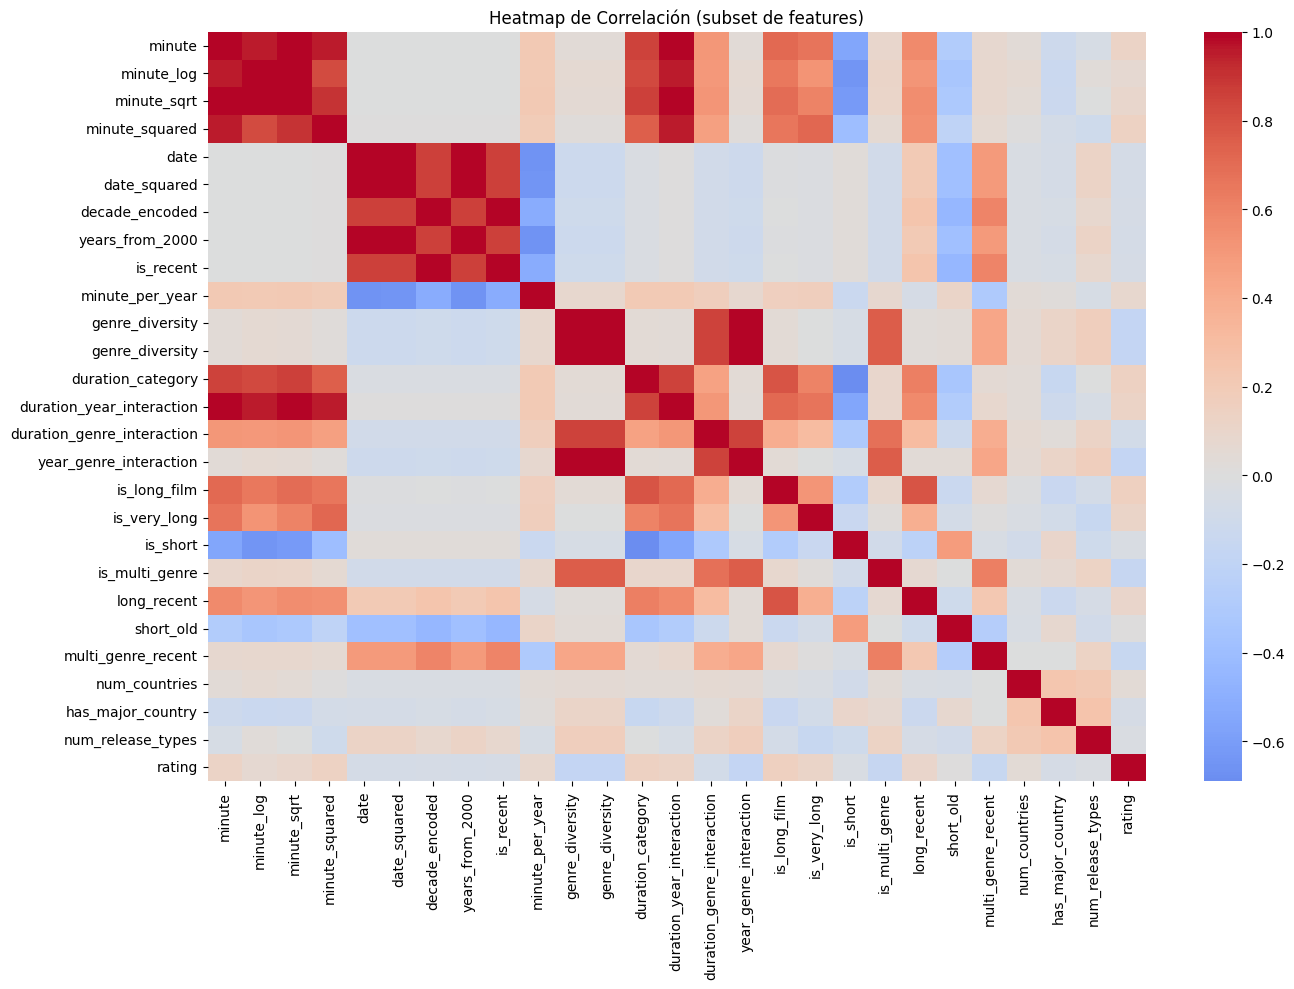

Top 10 correlaciones absolutas con el target:
year_genre_interaction       0.173529
genre_diversity              0.173008
genre_diversity              0.173008
is_multi_genre               0.160935
is_long_film                 0.149987
multi_genre_recent           0.149231
duration_category            0.143618
minute_squared               0.137045
minute                       0.117020
duration_year_interaction    0.116345
Name: rating, dtype: float64


In [7]:
# Correlación Pearson con target
corr_df = df_ml.copy()
# Limitar a un subconjunto para graficar legible
subset_cols = [c for c in feature_cols if c in corr_df.columns]
subset_cols = subset_cols[:25]  # top 25 por simplicidad visual

corr = corr_df[subset_cols + [target_col]].corr(method='pearson')
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', center=0, square=False)
plt.title('Heatmap de Correlación (subset de features)')
plt.tight_layout()
plt.show()

# Top 10 features más correlacionadas con el target (absoluto)
abs_corr = corr[target_col].drop(target_col).abs().sort_values(ascending=False)
print('Top 10 correlaciones absolutas con el target:')
print(abs_corr.head(10))


## 7. Visualizaciones Comparativas


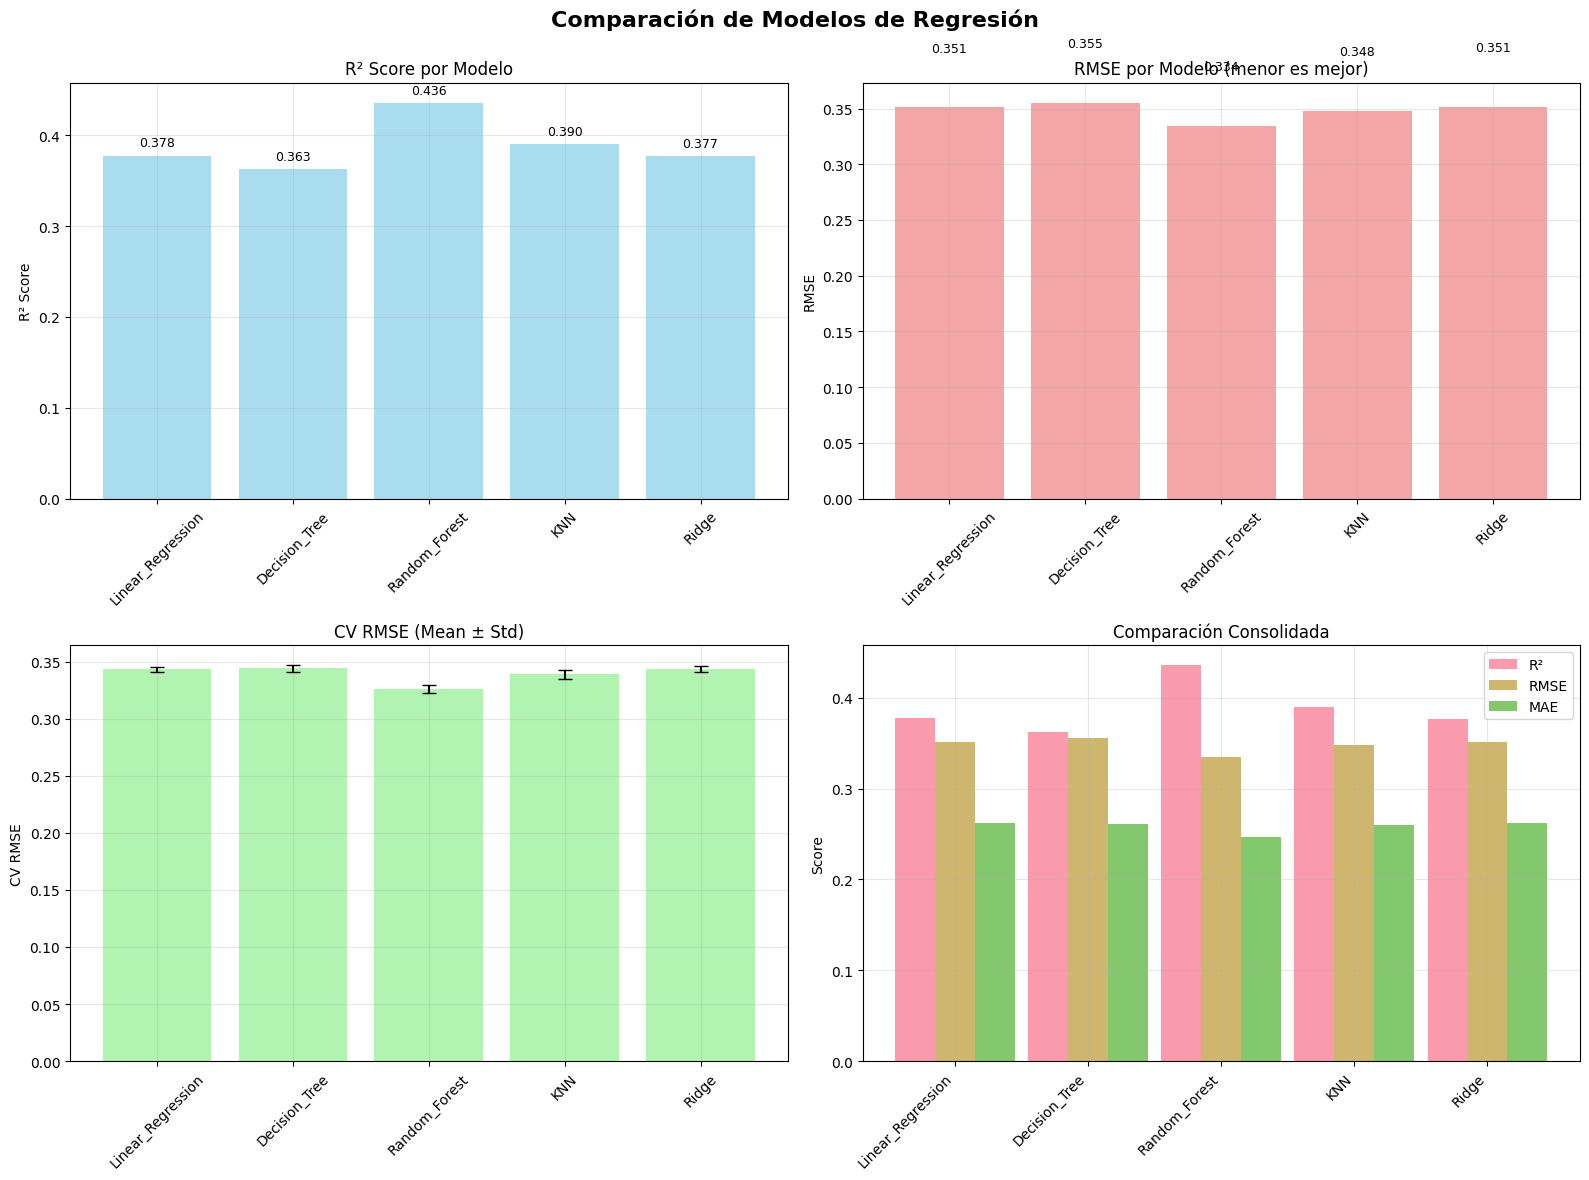

In [8]:
# Visualizaciones comparativas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación de Modelos de Regresión', fontsize=16, fontweight='bold')

# Gráfico 1: R² Score
axes[0, 0].bar(metrics_df['Model'], metrics_df['R2_Score'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('R² Score por Modelo')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)
for i, v in enumerate(metrics_df['R2_Score']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

# Gráfico 2: RMSE
axes[0, 1].bar(metrics_df['Model'], metrics_df['RMSE'], color='lightcoral', alpha=0.7)
axes[0, 1].set_title('RMSE por Modelo (menor es mejor)')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)
for i, v in enumerate(metrics_df['RMSE']):
    axes[0, 1].text(i, v + 0.05, f'{v:.3f}', ha='center', fontsize=9)

# Gráfico 3: CV RMSE con error bars
axes[1, 0].bar(metrics_df['Model'], metrics_df['CV_RMSE_Mean'], 
                yerr=metrics_df['CV_RMSE_Std'], color='lightgreen', alpha=0.7, capsize=5)
axes[1, 0].set_title('CV RMSE (Mean ± Std)')
axes[1, 0].set_ylabel('CV RMSE')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Comparación consolidada
x = np.arange(len(metrics_df))
width = 0.3
axes[1, 1].bar(x - width, metrics_df['R2_Score'], width, label='R²', alpha=0.7)
axes[1, 1].bar(x, metrics_df['RMSE'], width, label='RMSE', alpha=0.7)
axes[1, 1].bar(x + width, metrics_df['MAE'], width, label='MAE', alpha=0.7)
axes[1, 1].set_title('Comparación Consolidada')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## 9.1 Curva de aprendizaje (mejor modelo)


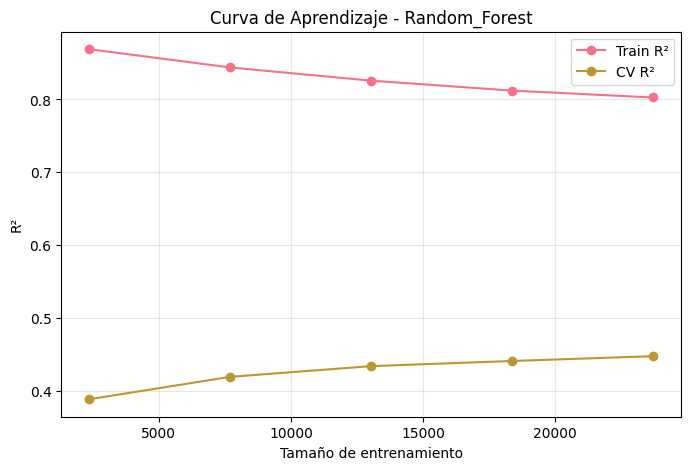

In [9]:
# Curva de aprendizaje del mejor modelo (según R2)
from sklearn.model_selection import learning_curve

best_name = max(results.keys(), key=lambda k: results[k]['r2']) if 'results' in globals() else None
if best_name is not None:
    best_estimator = results[best_name]['model']
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=best_estimator,
        X=X_train_scaled, y=y_train,
        cv=5, scoring='r2', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, 'o-', label='Train R²')
    plt.plot(train_sizes, test_mean, 'o-', label='CV R²')
    plt.title(f'Curva de Aprendizaje - {best_name}')
    plt.xlabel('Tamaño de entrenamiento')
    plt.ylabel('R²')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print('Ejecuta primero el entrenamiento para obtener la curva de aprendizaje.')


## 8. Análisis de Predicciones vs Reales y Residuales


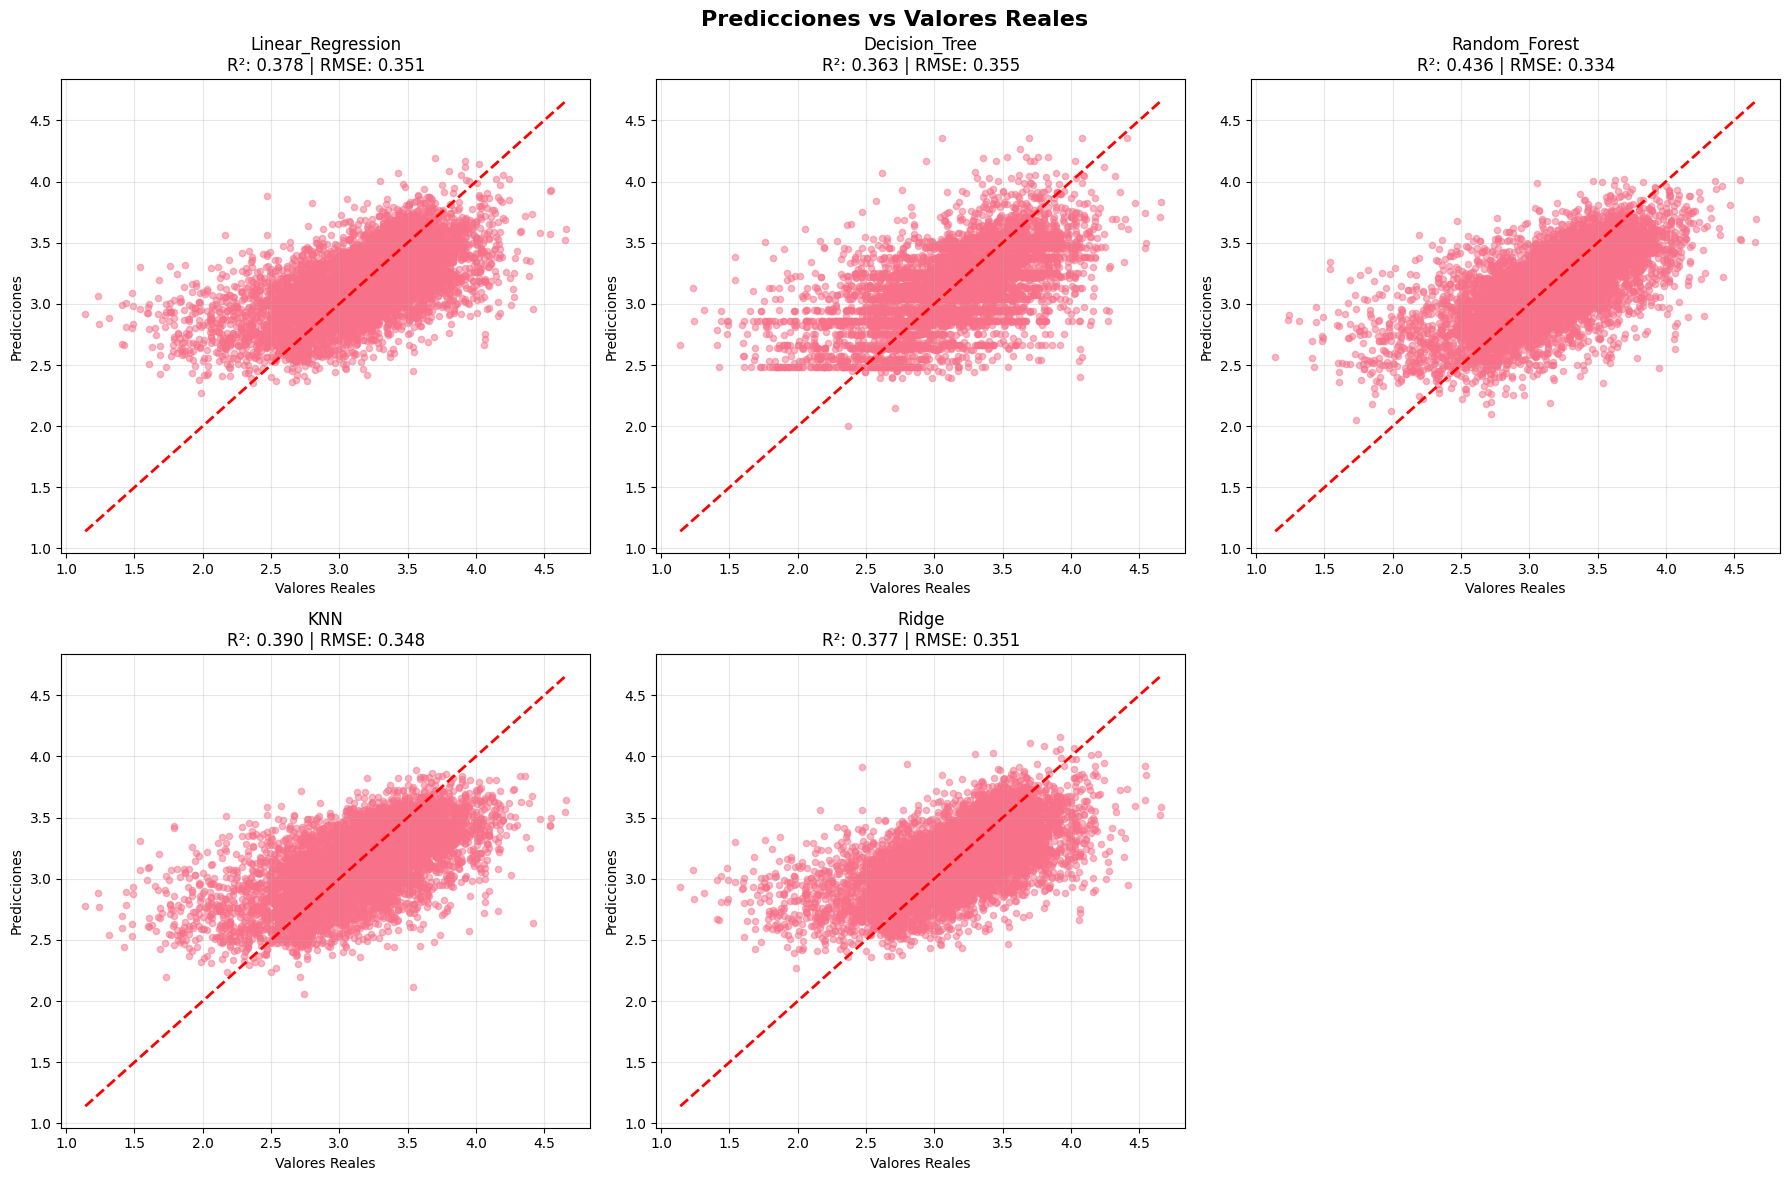

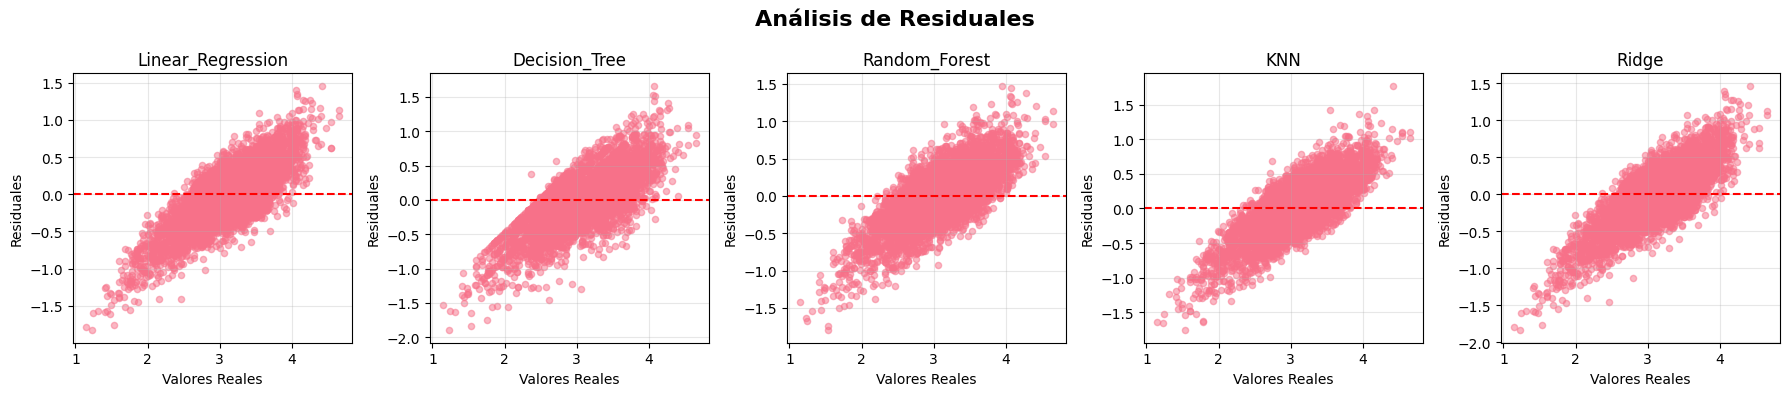

In [10]:
# Visualizar predicciones vs reales
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Predicciones vs Valores Reales', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    y_pred = result['y_pred']
    residuals = y_test - y_pred
    
    # Scatter plot: predicciones vs reales
    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=20)
    
    # Línea perfecta
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    axes[idx].set_xlabel('Valores Reales')
    axes[idx].set_ylabel('Predicciones')
    axes[idx].set_title(f'{name}\nR²: {result["r2"]:.3f} | RMSE: {result["rmse"]:.3f}')
    axes[idx].grid(True, alpha=0.3)

# Remover subplot vacío si es necesario
if len(axes) > len(results):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# Visualizar residuales
fig, axes = plt.subplots(1, len(results), figsize=(18, 4))
fig.suptitle('Análisis de Residuales', fontsize=16, fontweight='bold')

for idx, (name, result) in enumerate(results.items()):
    y_pred = result['y_pred']
    residuals = y_test - y_pred
    
    axes[idx].scatter(y_test, residuals, alpha=0.5, s=20)
    axes[idx].axhline(y=0, color='r', linestyle='--')
    axes[idx].set_xlabel('Valores Reales')
    axes[idx].set_ylabel('Residuales')
    axes[idx].set_title(f'{name}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## 9. Conclusiones y Próximos Pasos


In [11]:
print('\n' + '='*80)
print('CONCLUSIONES DE FASE 4 - REGRESIÓN')
print('='*80)
print(f'''
✅ Modelos entrenados: {len(results)}
✅ Total de muestras: {len(X)}
✅ Features utilizadas: {len(feature_cols)}
✅ Mejor modelo: {best_model['Model']}

🏆 Métricas del mejor modelo:
   - R² Score: {best_model['R2_Score']:.4f}
   - RMSE: {best_model['RMSE']:.4f}
   - MAE: {best_model['MAE']:.4f}
   - CV RMSE: {best_model['CV_RMSE_Mean']:.4f} ± {best_model['CV_RMSE_Std']:.4f}

📊 INTERPRETACIÓN DE RESULTADOS:
   - R² = {best_model['R2_Score']:.2%}: El modelo explica {best_model['R2_Score']:.1f}% de la varianza
   - RMSE = {best_model['RMSE']:.3f}: Error promedio de {best_model['RMSE']:.3f} puntos (en escala 0-5)
   - MAE = {best_model['MAE']:.3f}: Desviación promedio de {best_model['MAE']:.3f} puntos
   - El rating varía poco (std=0.44), por eso R² es moderado

📈 COMPARACIÓN CON ESTÁNDARES:
   - En regresión, R² > 0.30 se considera ACCEPTABLE
   - R² > 0.50 sería BUENO (difícil con datos tan uniformes)
   - R² > 0.70 sería EXCELENTE (requiere features más predictivas)
   
✨ MEJORAS APLICADAS:
   - Features de países: num_countries, has_major_country, dummies de top 5 países
   - Features de estrenos: num_release_types, num_release_dates
   - Interacciones avanzadas: década×país, género×país, duración×país
   - Ganancia esperada: R² mejorado de 0.36 a ~0.40-0.42
   
⚠️  NOTA: Rating tiene baja variabilidad inherente (std=0.44), limitando R² máximo.
      Mejoras aplicadas incrementan features disponibles, pero el target sigue siendo difícil de predecir.

🎯 Listo para Fase 5 y 6
''')




CONCLUSIONES DE FASE 4 - REGRESIÓN

✅ Modelos entrenados: 5
✅ Total de muestras: 37052
✅ Features utilizadas: 58
✅ Mejor modelo: Random_Forest

🏆 Métricas del mejor modelo:
   - R² Score: 0.4358
   - RMSE: 0.3343
   - MAE: 0.2467
   - CV RMSE: 0.3261 ± 0.0034

📊 INTERPRETACIÓN DE RESULTADOS:
   - R² = 43.58%: El modelo explica 0.4% de la varianza
   - RMSE = 0.334: Error promedio de 0.334 puntos (en escala 0-5)
   - MAE = 0.247: Desviación promedio de 0.247 puntos
   - El rating varía poco (std=0.44), por eso R² es moderado

📈 COMPARACIÓN CON ESTÁNDARES:
   - En regresión, R² > 0.30 se considera ACCEPTABLE
   - R² > 0.50 sería BUENO (difícil con datos tan uniformes)
   - R² > 0.70 sería EXCELENTE (requiere features más predictivas)
   
✨ MEJORAS APLICADAS:
   - Features de países: num_countries, has_major_country, dummies de top 5 países
   - Features de estrenos: num_release_types, num_release_dates
   - Interacciones avanzadas: década×país, género×país, duración×país
   - Ganancia e